In [1]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
# matplotlib.rcParams['lines.markersize'] = 3

import numpy as np
# %matplotlib notebook


import matplotlib.pyplot as plt
matplotlib.get_backend()

'module://ipykernel.pylab.backend_inline'

## Pressure Potential 1D

In [2]:
def getY(x, a, b, c):
    return a*(1.+(x/b)**2)**(-c)
def getFunction(x, a, b, c):
    return x, getY(x, a, b, c)
def getFunctionDeriv(x, a, b, c):
    return -(2*a*c*x*(1 + x^2/b^2)^(-1-c))/b^2
def getFTFunction(ks, a, b, c):
	import scipy.special
	#assumes profile in real space: a*(1+(x/b)^2)^(-c)
# 	print('PressureFourierTransTheoretical: assuming units(distance); cm')
	return ks, 2**(1.-c)*a/(b**2)**(-1./4.-c/2.)*abs(ks)**(-1./2.+c)*scipy.special.kv(1./2.-c, np.array(abs(ks)*abs(b)), dtype=np.complex)/scipy.special.gamma(np.complex(c))

$P(x)=a\left(1+\left(\frac{x}{b}\right)^2\right)^{-c} \\
P^\prime(x)=-\frac{2 a c x \left(1 + \left(\frac{x}{b}\right)^2\right)^{(-1 - c)}}{b^2} \\
\hat{P}(k)=\frac{2^{1-c}{a}{b^{2\left(\frac{1}{4}+\frac{c}{2}\right)}}|k|^{-\frac{1}{2}+c} K_v\left(\frac{1}{2}-c,k|b|\right)}{\Gamma(c)}$

In [3]:
functionReal = lambda x,p: getFunction(x, *p)
functionFourier = lambda x,p: getFTFunction(x, *p)

In [4]:
def doFFT(n=1000, n_pad=0, deltax=1, constants = [5e-10, 26., 0.67]):
    x1 = (-(n+n_pad)/2 + 1)*deltax;
    grid = np.arange(x1, x1+(n)*deltax, deltax)
#     print(f"grid: {grid}")
    MaxX = np.max(grid)
    MaxX = grid[-1]-grid[0]
    spacing = deltax
    grid, samples = functionReal(grid, constants)
    samples = np.concatenate((samples,np.zeros(n_pad)))
    grid = np.arange(x1, x1+(n+n_pad)*deltax, deltax)
    factor = np.sqrt(n/(2*np.pi))*deltax*np.exp(-2*np.pi*np.complex(0,1)*x1/(n*deltax)*np.arange(0, n+n_pad))
    transform = np.fft.fft(samples, norm='ortho') * factor
    ks = np.fft.fftfreq(n+n_pad, d=deltax)*2*np.pi
    return ks, transform, MaxX, spacing, abs(functionFourier(ks,constants)[1]), constants, grid

/home/kristian/miniconda3/envs/arepoR/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in power
  # This is added back by InteractiveShellApp.init_path()
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


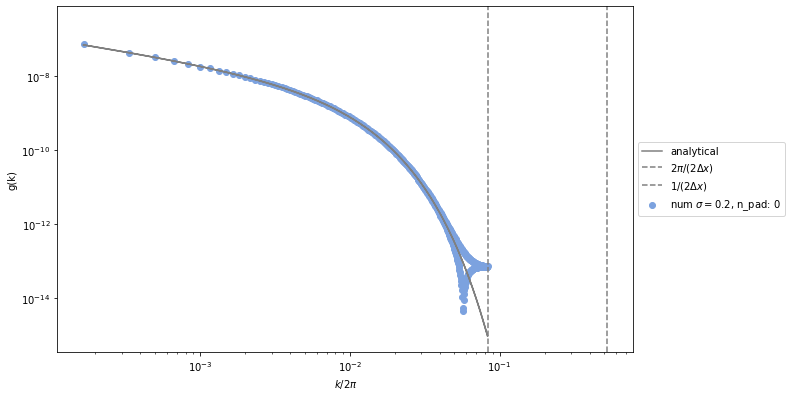

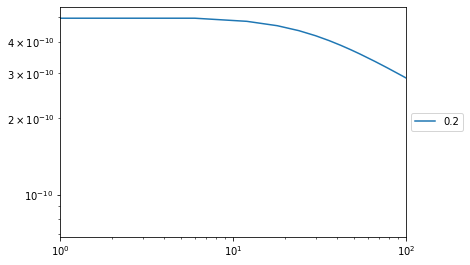

In [5]:
Colors = ['#7ca2df','#2565ca','#0e2850','#bb596d','#9F132F','#4f0917','#ffd27f','#FFA500','#664200']
Markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
#sigma, mu, a, b
n = 1000
N_pad = [0]#,0]
deltax = 6000. / n
fig = plt.figure(figsize=np.array([10,6]))
ax = plt.axes([0.15,0.15,0.8,.8])
a, b, c = 5e-10, 26., 1
Nskip = 1
Constants = [[a, b, 0.2]]#, [a, b, 0.67], [a, b, 1]]#, [a, b, 2]]
for constants,c in zip(Constants, Colors):
    for marker, n_pad in zip(Markers, N_pad):
        ks, transform, MaxX, spacing, anaFT, constants, grid = doFFT(n=n, n_pad=n_pad, deltax=deltax, constants = constants)
    #     ax.plot(2*np.pi/abs(ks), abs(anaFT), c='gray', label='analytical')
    #     ax.scatter(2*np.pi/np.array([ks,abs(transform)**1])[0],np.array([ks,abs(transform)**1])[1], label='num $\sigma=$%g' %(constants[0]))
        ax.plot(abs(ks)/(2*np.pi), abs(anaFT), c='gray', label='analytical')
        ax.scatter(*[x[::Nskip] if index == 1 else x[::Nskip]/(2*np.pi) for index,x in enumerate(np.array([ks,abs(transform)**1]))], c=c, marker=marker, label='num $\sigma=$%g, n_pad: %i' %(constants[-1], n_pad))

plt.axvline(x=2*np.pi/spacing/2, label=r'$2\pi/(2\Delta x)$', c='grey', ls='--')#can probe scales 2*dx
plt.axvline(x=1/spacing/2, label=r'$1/(2\Delta x)$', c='grey', ls='--')#can probe scales 2*dx
# plt.axvline(x=2*np.pi/spacing/8, label=r'$2\pi/(4\Delta x)$', c='grey', ls=':')#can probe scales 2*dx
# plt.axvline(x=0.5, label=r'pad ok', c='grey')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$k/2\pi$')
ax.set_ylabel('g(k)')
# ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

# fig.canvas.draw()
# labels = [item.get_text() for item in ax.get_xticklabels()]
# labels = ['%s'%(2*np.pi/float(l)) for l in labels if float(l)!=0]
# ax.set_xticklabels(labels)
# ax.set_ylim([1e-20,1e-7])
plt.legend(loc='center left', framealpha=.8, fancybox=True, bbox_to_anchor=(1,0.5))

# fig.savefig('TestingFourierAnalyticsPressureProfileGXPython.pdf', dpi=450)


fig = plt.figure()
ax1 = plt.axes([0.15,0.15,0.8,.8])
# print(grid[grid>0])
for constants in Constants:
    ax1.plot(*functionReal(grid,constants), label='%g' %constants[-1])
ax1.set_xlim([1e0,1e2])
ax1.set_xscale('log')
ax1.set_yscale('log')
plt.legend(loc='center left', framealpha=.8, fancybox=True, bbox_to_anchor=(1,0.5))

plt.show()

In [ ]:
def doFFT(n=1000, n_pad=0, deltax=1, constants = [5e-10, 26., 0.67]):
    x1 = (-(n+n_pad)/2 + 1)*deltax;
    grid = np.arange(x1, x1+(n)*deltax, deltax)
#     print(f"grid: {grid}")
    MaxX = np.max(grid)
    MaxX = grid[-1]-grid[0]
    spacing = deltax
    grid, samples = functionReal(grid, constants)
    samples = np.concatenate((samples,np.zeros(n_pad)))
    grid = np.arange(x1, x1+(n+n_pad)*deltax, deltax)
    factor = np.sqrt(n/(2*np.pi))*deltax*np.exp(-2*np.pi*np.complex(0,1)*x1/(n*deltax)*np.arange(0, n+n_pad))
    transform = np.fft.fft(samples, norm='ortho') * factor
    ks = np.fft.fftfreq(n+n_pad, d=deltax)*2*np.pi
    return ks, transform, MaxX, spacing, abs(functionFourier(ks,constants)[1]), constants, grid

### FINUFFT (No inverse appears available) 

In [13]:
import finufft 

In [14]:
x1 = (-(n+n_pad)/2 + 1)*deltax
grid = np.arange(x1, x1+(n)*deltax, deltax)
grid, samples = functionReal(grid, constants)

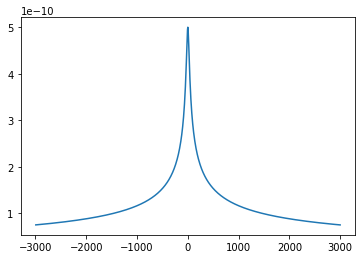

In [15]:
plt.plot(grid,samples)

In [18]:
x = grid
c = samples
N = 1024
f = finufft.nufft1d1?

Signature:
finufft.nufft1d1(
    x,
    c,
    n_modes=None,
    out=None,
    eps=1e-06,
    isign=1,
    **kwargs,
)
Docstring:
1D type-1 (nonuniform to uniform) complex NUFFT

::

          M-1
  f[k1] = SUM c[j] exp(+/-i k1 x(j))
          j=0

      for -N1/2 <= k1 <= (N1-1)/2

Args:
  x         (float[M]): nonuniform points, valid only in [-3pi, 3pi].
  c         (complex[M] or complex[ntransf, M]): source strengths.
  n_modes   (integer or integer tuple of length 1, optional): number of
            uniform Fourier modes requested (N1, ). May be even or odd; in
            either case, modes k1 are integers satisfying -N1/2 <= k1 <=
            (N1-1)/2. Must be specified if ``out`` is not given.
  out       (complex[N1] or complex[ntransf, N1], optional): output array
            for Fourier mode values. If ``n_modes`` is specifed, the shape
            must match, otherwise ``n_modes`` is inferred from ``out``.
  eps       (float, optional): precision requested (>1e-16).
  isig

In [25]:
import finufft
import numpy as np
# number of nonuniform points
M = 100

# the nonuniform points
x = 2 * np.pi * np.random.uniform(size=M)
y = 2 * np.pi * np.random.uniform(size=M)
z = 2 * np.pi * np.random.uniform(size=M)

# number of Fourier modes
N1, N2, N3 = 50, 75, 100

# the Fourier mode coefficients
f = (np.random.standard_normal(size=(N1, N2, N3))
     + 1J * np.random.standard_normal(size=(N1, N2, N3)))

# calculate the type-2 NUFFT
c = finufft.nufft3d2(x, y, z, f)

In [30]:
np.shape(f)

(50, 75, 100)

### PYNUFFT

In [23]:
# https://www.mdpi.com/2313-433X/4/3/51/pdf
#Lin, Jyh-Miin. “Python Non-Uniform Fast Fourier Transform (PyNUFFT): An Accelerated Non-Cartesian MRI Package on a Heterogeneous Platform (CPU/GPU).” Journal of Imaging 4.3 (2018): 51.

In [38]:
import numpy as np
from pynufft import NUFFT

In [124]:
NufftObj = NUFFT()
N = 2560
M = 2000
om = numpy.random.randn(M,1)
print(f"{om.shape}")
Nd = (N,)
Kd = (2*N,)
Jd = (6,)
NufftObj.plan(om, Nd, Kd, Jd)

(2000, 1)


0

31.41592653589793


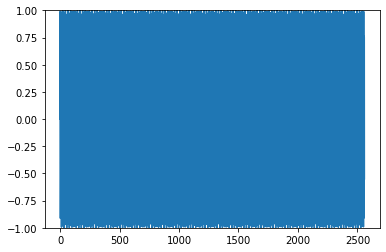

In [135]:
import numpy
import matplotlib.pyplot as pyplot
MAX = 2*np.pi*100
x = np.linspace(0, MAX, N)
factor = 0.2
time_data = np.sin(2*np.pi*x/factor)
delta_intercept = 2*np.pi/factor
print(delta_intercept)
# time_data[96:128+32] = 1.0
pyplot.plot(time_data)
pyplot.ylim(-1,1)
pyplot.show()

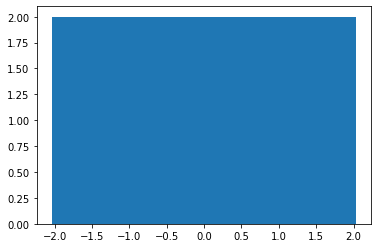

In [136]:
pyplot.hist(numpy.fft.fftfreq(M, MAX/N), bins=1000);

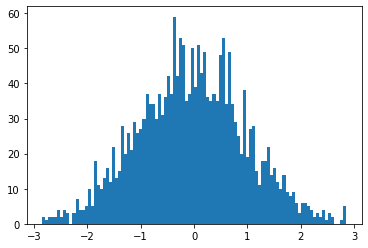

In [137]:
pyplot.hist(om, bins=100);

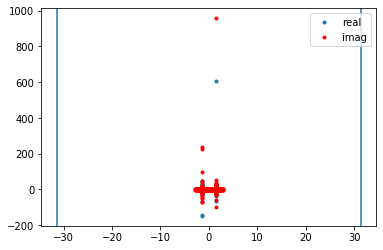

In [138]:
nufft_freq_data =NufftObj.forward(time_data, )
pyplot.plot(om,nufft_freq_data.real,'.', label='real')
pyplot.plot(om,nufft_freq_data.imag,'r.', label='imag')
pyplot.axvline(delta_intercept)
pyplot.axvline(-delta_intercept)
# pyplot.xlim([-0.1,0.1])
pyplot.legend()
pyplot.show()

In [117]:
restore_time = NufftObj.solve(nufft_freq_data,'cg', maxiter=3000)
restore_time2 = NufftObj.solve(nufft_freq_data,'L1TVOLS', maxiter=3000,rho=1)

/home/kristian/miniconda3/envs/arepoR/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/home/kristian/miniconda3/envs/arepoR/lib/python3.7/site-packages/pynufft/linalg/solve_cpu.py:110: RuntimeWarning: overflow encountered in true_divide
  xkp1 = nufft.k2xx_one2one( (nufft.xx2k_one2one(rhs)+1e-7) / (uker+1e-7))
/home/kristian/miniconda3/envs/arepoR/lib/python3.7/site-packages/pynufft/linalg/solve_cpu.py:139: RuntimeWarning: invalid value encountered in greater
  r =(s > threshold_value)*(s-threshold_value)/s#numpy.maximum(s - threshold_value ,  0.0)/s


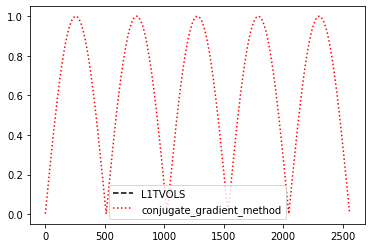

In [76]:
# im1,=pyplot.plot(numpy.abs(time_data),'r',label='original signal')
im3,=pyplot.plot(numpy.abs(restore_time2),'k--',label='L1TVOLS')
im4,=pyplot.plot(numpy.abs(restore_time),'r:',label='conjugate_gradient_method')
pyplot.legend()#[im1, im3,im4])
pyplot.show()

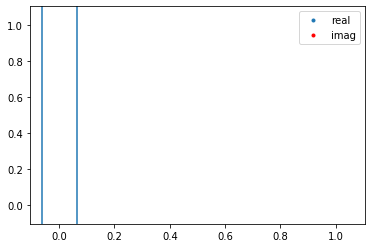

In [58]:
nufft_freq_data =NufftObj.forward(restore_time2)
pyplot.plot(om,nufft_freq_data.real,'.', label='real')
pyplot.plot(om,nufft_freq_data.imag,'r.', label='imag')
pyplot.axvline(delta_intercept)
pyplot.axvline(-delta_intercept)
pyplot.legend()
pyplot.show()

In [84]:
restore_time = NufftObj.solve(nufft_freq_data,'cg', maxiter=30)
restore_time2 = NufftObj.solve(nufft_freq_data,'L1TVOLS', maxiter=30,rho=1)

/home/kristian/miniconda3/envs/arepoR/lib/python3.7/site-packages/pynufft/linalg/solve_cpu.py:110: RuntimeWarning: overflow encountered in true_divide
  xkp1 = nufft.k2xx_one2one( (nufft.xx2k_one2one(rhs)+1e-7) / (uker+1e-7))
/home/kristian/miniconda3/envs/arepoR/lib/python3.7/site-packages/pynufft/linalg/solve_cpu.py:139: RuntimeWarning: invalid value encountered in greater
  r =(s > threshold_value)*(s-threshold_value)/s#numpy.maximum(s - threshold_value ,  0.0)/s


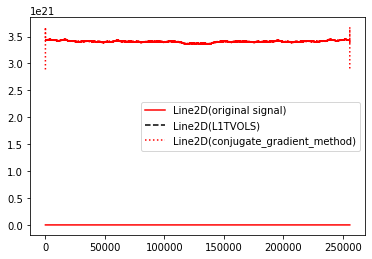

In [85]:
im1,=pyplot.plot(numpy.abs(time_data),'r',label='original signal')
im3,=pyplot.plot(numpy.abs(restore_time2),'k--',label='L1TVOLS')
im4,=pyplot.plot(numpy.abs(restore_time),'r:',label='conjugate_gradient_method')
pyplot.legend([im1, im3,im4])
pyplot.show()

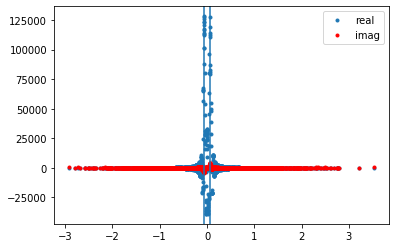

In [63]:
nufft_freq_data =NufftObj.forward(restore_time2*1e3)
pyplot.plot(om,nufft_freq_data.real,'.', label='real')
pyplot.plot(om,nufft_freq_data.imag,'r.', label='imag')
pyplot.axvline(delta_intercept)
pyplot.axvline(-delta_intercept)
pyplot.legend()
pyplot.show()